# Likelihood evaluations for Palanque-Delabrouille et al. (2013)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import camb_cosmo
import fit_linP
import likelihood
import lya_theory

### Read P1D data from Palanque-Delabrouille et al. (2013)

In [2]:
data=data_PD2013.P1D_PD2013(blind_data=False,zmin=2.1,zmax=4.8)
zs=data.z
k_kms=data.k

### Specify suite of simulations to use, read P1D arxiv and setup simplest emulator

In [3]:
basedir='../../p1d_emulator/sim_suites/emulator_512_18062019/'
#basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
kmax_Mpc=3.0
p1d_label=None
skewers_label=None
undersample_z=1
max_arxiv_size=2000
paramList=["Delta2_p","mF","sigT_Mpc","gamma","kF_Mpc"]
emu_type='kGP'
if emu_type=='polyGP':
    emu=gp_emulator.PolyfitGPEmulator(basedir,p1d_label,skewers_label,kmax_Mpc=kmax_Mpc,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                verbose=True,paramList=paramList,train=True)
elif emu_type=='kGP':
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                verbose=True,paramList=paramList,train=True)
elif emu_type=='linear':
    # specify parameters to emulate
    emulate_slope=False
    emulate_growth=False
    emulate_running=False
    emulate_pressure=True
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,kmax_Mpc=kmax_Mpc,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                emulate_slope=emulate_slope,emulate_running=emulate_running,
                                emulate_pressure=emulate_pressure,emulate_growth=emulate_growth,verbose=False)
elif emu_type=='NGP':
    emu=simplest_emulator.SimplestEmulator(basedir,p1d_label,skewers_label,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                verbose=False)
else:
    raise ValueError('wrong emulator type '+emu_type)

latin hyper-cube data {'param_space': {'heat_amp': {'ip': 0, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$H_A$'}, 'heat_slo': {'ip': 1, 'min_val': -0.5, 'max_val': 0.5, 'latex': '$H_S$'}, 'z_rei': {'ip': 2, 'min_val': 6.0, 'max_val': 12.0, 'latex': '$z_r$'}}, 'nsamples': 6, 'samples': {'0': [1.125, -0.08333333333333337, 9.5], '1': [1.875, 0.25, 8.5], '2': [0.875, 0.08333333333333326, 10.5], '3': [1.375, -0.25, 6.5], '4': [0.625, 0.41666666666666663, 7.5], '5': [1.625, -0.4166666666666667, 11.5]}}
simulation suite has 6 samples
0 sample has sim params = [1.125, -0.08333333333333337, 9.5]
simulation has 20 redshifts
undersample_z = 1
../../p1d_emulator/sim_suites/emulator_512_18062019//sim_pair_0/sim_plus/p1d_0_Ns100_wM0.07.json snapshot does not have p1d
../../p1d_emulator/sim_suites/emulator_512_18062019//sim_pair_0/sim_plus/p1d_1_Ns100_wM0.07.json snapshot does not have p1d
../../p1d_emulator/sim_suites/emulator_512_18062019//sim_pair_0/sim_plus/p1d_2_Ns100_wM0.07.json snapshot does not

### Setup Lyman alpha theory

In [4]:
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=False)

Note: redshifts have been re-sorted (earliest first)


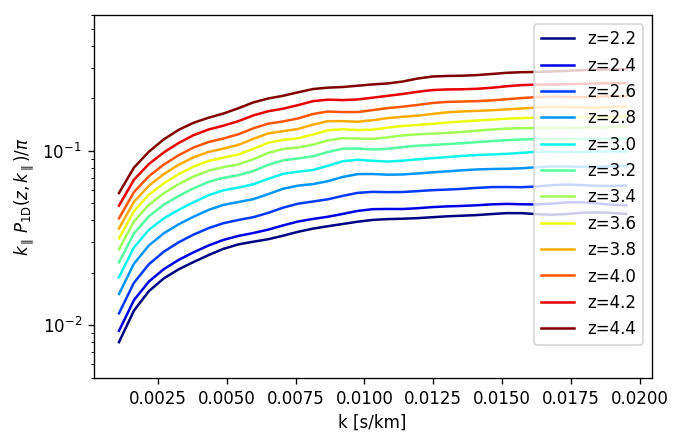

In [5]:
theory.plot_p1d(k_kms,plot_every_iz=1)

### Compare emulator calls to models in arxiv, for all redhsifts

In [6]:
free_parameters=['ln_tau_0']
like=likelihood.Likelihood(data=data,theory=theory,free_parameters=free_parameters)
like.go_silent()

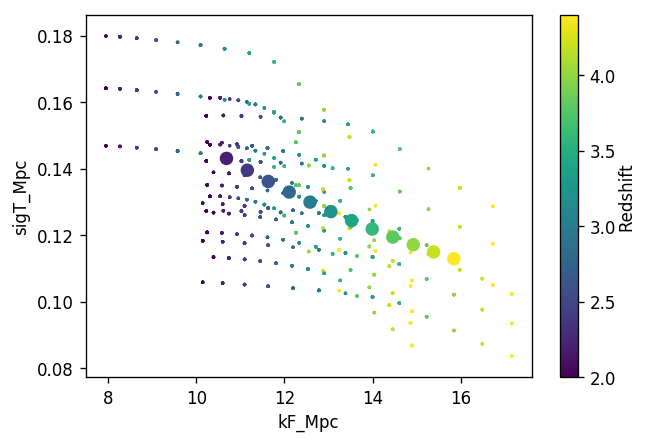

In [7]:
like.overplot_emulator_calls('kF_Mpc','sigT_Mpc')

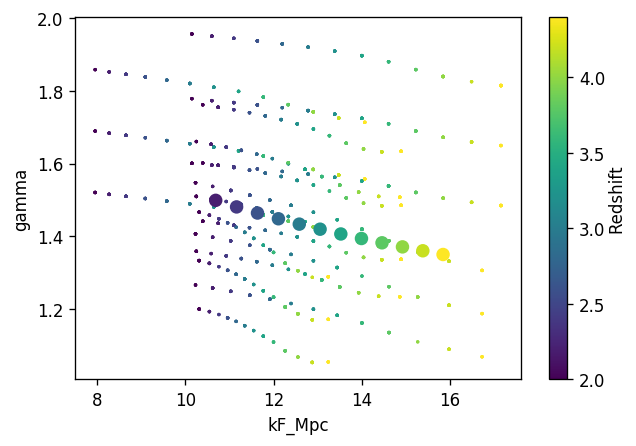

In [8]:
like.overplot_emulator_calls('kF_Mpc','gamma')

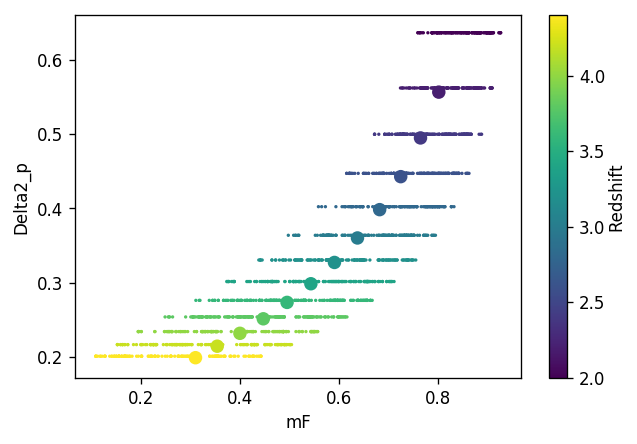

In [9]:
like.overplot_emulator_calls('mF','Delta2_p',tau_scalings=True)

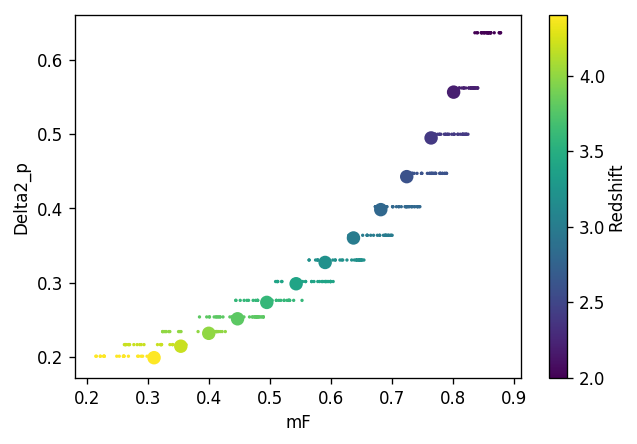

In [10]:
like.overplot_emulator_calls('mF','Delta2_p',tau_scalings=False)

### For each redshift, plot data vs model

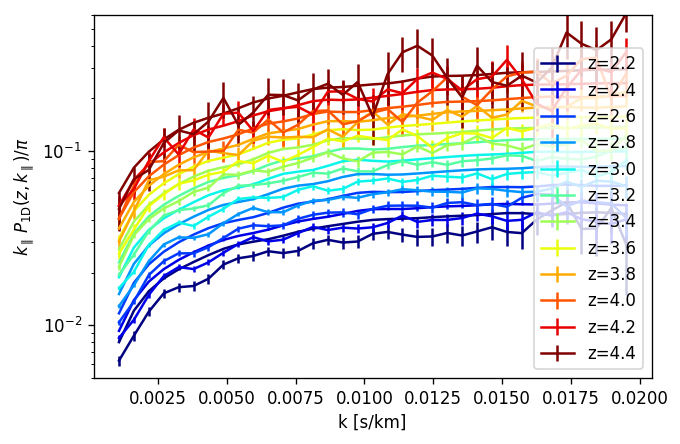

In [11]:
like.plot_p1d(plot_every_iz=1)

### Plot chi2 vs mean optical depth parameter

In [12]:
chi2=like.get_chi2()
print('chi2 =',chi2)

chi2 = 22196.3843425


In [13]:
# will explore all range of effective optical depth at z=3
value_in_cube=np.linspace(0.0,1.0,100)
Np=len(value_in_cube)
chi2=np.empty(Np)
tau0=np.empty(Np)
par=like.free_params[0]
for i in range(Np):
    ln_tau_0=par.value_from_cube(value_in_cube[i])
    tau0[i]=np.exp(ln_tau_0)
    chi2[i] =like.get_chi2(values=[value_in_cube[i]])
    #print(i,value_in_cube[i],tau0[i],np.exp(-tau0[i]),'chi2 =',chi2[i])

Text(0, 0.5, '$\\chi^2$')

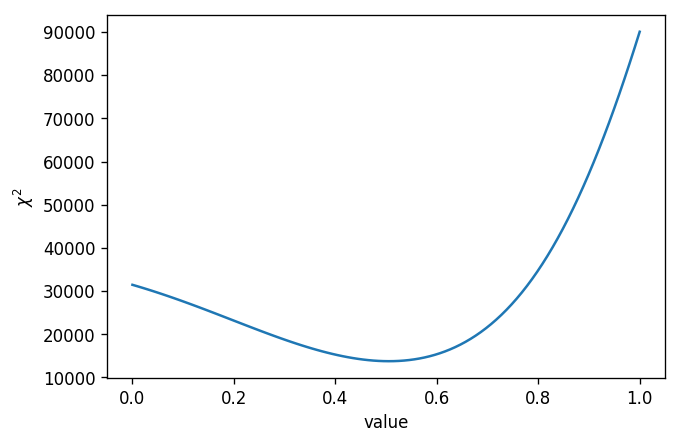

In [14]:
plt.plot(value_in_cube,chi2)
plt.xlabel('value')
plt.ylabel(r'$\chi^2$')

Text(0, 0.5, '$\\chi^2$')

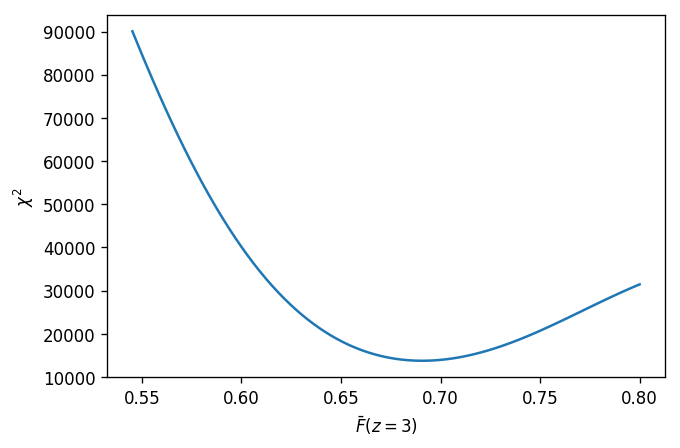

In [15]:
plt.plot(np.exp(-tau0),chi2)
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')

In [16]:
p1d,error=theory.get_p1d_kms(k_kms=k_kms,returnErrors=True)

In [17]:
p1d[0]

array([ 32.89370654,  33.30789598,  32.35343811,  30.64515321,
        28.73255379,  27.03584828,  25.86235504,  24.93014429,
        23.75648959,  22.32691351,  21.1128255 ,  20.41248081,
        19.95521759,  19.40283142,  18.74651727,  18.15474298,
        17.6718621 ,  17.1557647 ,  16.49575688,  15.7833648 ,
        15.1576256 ,  14.64283223,  14.17362069,  13.71766984,
        13.31849682,  13.01055623,  12.70429005,  12.26547809,
        11.71455227,  11.2446489 ,  10.97933333,  10.79394802,
        10.52848065,  10.16175266,   9.75432548])

In [18]:
error[0]

array([ 1.19795685,  1.18786021,  1.13746032,  1.07280708,  1.01250865,
        0.96043912,  0.91744023,  0.87651413,  0.82830949,  0.77752321,
        0.74341882,  0.73551703,  0.73304997,  0.71290169,  0.68115002,
        0.65948815,  0.65350876,  0.64472613,  0.61828838,  0.58361623,
        0.55593641,  0.53828729,  0.52417686,  0.50940933,  0.49524791,
        0.48331429,  0.47295733,  0.46263701,  0.45165965,  0.44027878,
        0.42878028,  0.41739481,  0.40634524,  0.39588622,  0.38628671])

Text(0, 0.5, '$k_\\parallel \\, P_{\\rm 1D}(z,k_\\parallel) / \\pi$')

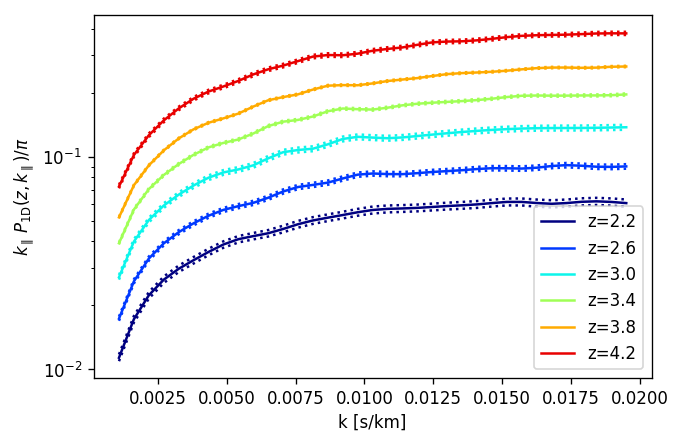

In [19]:
# plot only few redshifts for clarity
Nz=len(zs)
plot_every_iz=2
for iz in range(0,Nz,plot_every_iz):
    # acess data for this redshift
    z=zs[iz]
    p1d_iz=p1d[iz]
    error_iz=error[iz]
    # plot everything
    col = plt.cm.jet(iz/(Nz-1))
    plt.plot(k_kms,p1d_iz*k_kms/np.pi,color=col,ls='-',label='z=%.1f'%z)
    plt.plot(k_kms,(p1d_iz+error_iz)*k_kms/np.pi,color=col,ls=':')
    plt.plot(k_kms,(p1d_iz-error_iz)*k_kms/np.pi,color=col,ls=':')

plt.yscale('log')
plt.legend()
plt.xlabel('k [s/km]')
plt.ylabel(r'$k_\parallel \, P_{\rm 1D}(z,k_\parallel) / \pi$')
#plt.ylim(0.005,0.6)

In [20]:
iz=0
data_cov=data.get_cov_iz(iz)
emu_cov=np.outer(error[iz],error[iz]) 

In [21]:
cov=data_cov+emu_cov

Text(0.5, 1.05, 'Covariance matrix')

<Figure size 960x960 with 0 Axes>

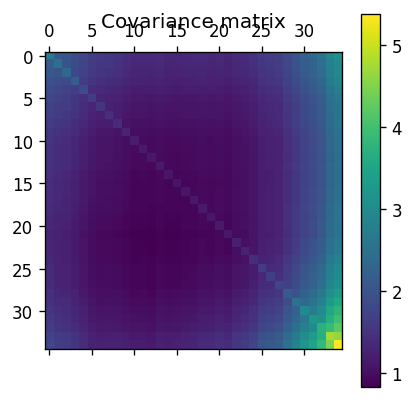

In [22]:
plt.figure(figsize=[8,8])
plt.matshow(cov)
plt.colorbar()
plt.title('Covariance matrix')

Text(0.5, 1.05, 'Emulator covariance matrix')

<Figure size 960x960 with 0 Axes>

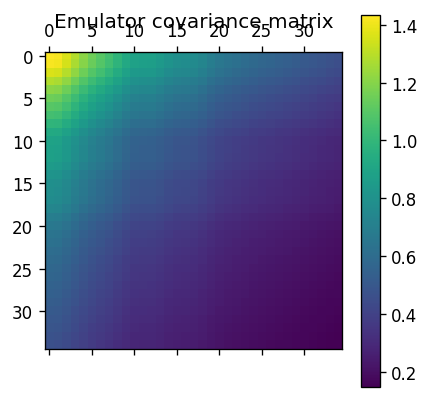

In [23]:
plt.figure(figsize=[8,8])
plt.matshow(emu_cov)
plt.colorbar()
plt.title('Emulator covariance matrix')

Text(0.5, 1.05, 'Data covariance matrix')

<Figure size 960x960 with 0 Axes>

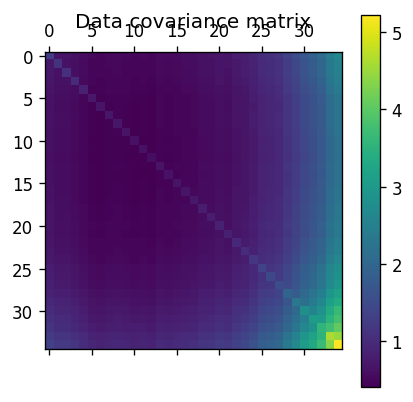

In [24]:
plt.figure(figsize=[8,8])
plt.matshow(data_cov)
plt.colorbar()
plt.title('Data covariance matrix')